# Downloading Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import requests
import tarfile
import os
import pickle


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset



In [2]:
# take look one batch
def load_batch(file_path):
  with open(file_path, "rb") as f:
    # eencoing choose bytes eensuree reading
    data = pickle.load(f, encoding="bytes")
  return data

# use iterate load_batch to load all batches from the image dataset
def load_all_batches(data_dir):
  images = []
  labels = []
  for i in range(1, 6):  # Loop through data_batch_1 to data_batch_5
    batch = load_batch(os.path.join(data_dir, f"data_batch_{i}"))
    images.append(batch[b"data"])
    labels += batch[b"labels"]
  # concanate with vstack to wrap up all data_Batches
  return np.vstack(images), np.array(labels)

# subsample certain images from each classes
def subsample_classes(images, labels, per_classSamples=1000):
  # create a dictionary to keep each seprateely
  classwise_data = {i: [] for i in range(10)}
  sampled_images = []
  sampled_labels = []
  # initialize catrgory dictonary
  for i in range(len(labels)):
    classwise_data[labels[i]].append(images[i])

  for label, data in classwise_data.items():
    # conveert to np, easier to select sub-indexes
    data = np.array(data)
    # random choice geenerate random indexs
    indices = np.random.choice(data.shape[0], per_classSamples, replace=False)
    sampled_images.append(data[indices])
    # fill with class samples and their label
    sampled_labels.append(np.full(per_classSamples, label))
  # stack up the training and target samples
  sampled_images = np.vstack(sampled_images)
  sampled_labels = np.concatenate(sampled_labels)
  # shuffle the datasets to increase randomnss and reduce bias
  shuffled_indices = np.random.permutation(len(sampled_labels))
  return sampled_images[shuffled_indices], sampled_labels[shuffled_indices]


Download the CIFAR10
https://github.com/EN10/CIFAR/blob/master/load_cifar.py

Unzipping and extracting: https://stackoverflow.com/questions/12902540/read-a-gzip-file-in-python

In [3]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
response = requests.get(url)

with open("cifar-10-python.tar.gz", "wb") as file:
  file.write(response.content)

In [4]:
# unzip the dataset and take look what are the files
file_path = "cifar-10-python.tar.gz"

with tarfile.open(file_path, "r:gz") as tar:
  tar.extractall()
data_dir = "cifar-10-batches-py"
print(os.listdir(data_dir))


['data_batch_3', 'data_batch_5', 'data_batch_1', 'batches.meta', 'test_batch', 'data_batch_4', 'data_batch_2', 'readme.html']


### Take look a sample of training datapoint from data_Batch_!


In [5]:
batch_path = os.path.join(data_dir, "data_batch_1")
batch_data = load_batch(batch_path)

print(batch_data.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [6]:
# test = batch_data[b"data"]
# print(test.shape)

b'data':

A NumPy array of shape (10000, 3072) where each row represents a 32x32 image flattened into a vector.

b'labels':

A list of 10,000 integers corresponding to the labels (0–9).

In [7]:
# Get the images and labels
# filenames = [b'filenames']
images = batch_data[b"data"]
labels = batch_data[b"labels"]



Loading and plotting CIFAR-10:

https://github.com/devyhia/cifar-10/blob/master/Load%20%26%20Visualize%20CIFAR-10.ipynb

https://stackoverflow.com/questions/35995999/why-cifar-10-images-are-not-displayed-properly-using-matplotlib

Here, you need to note that the image size for plt.imshow should be (awidth x height x RGB i.e. (32 x 32 x 3). The default is (3 x 32 x 32), that's why l use: .T (which is the transpose of 32 x 32 x 3 = 3 x 32 x 32).

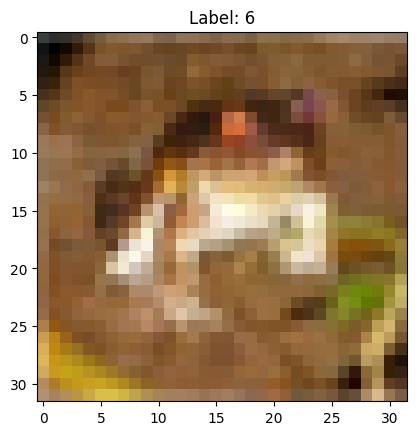

In [8]:
#image = images[0].reshape(32, 32, 3)
image = images[0].reshape(3, 32, 32).transpose(1, 2, 0)


plt.imshow(image)
plt.title("Label: {}".format(labels[0]))
plt.show()


### Next, load all 5 batch files's image and vstack them together

In [9]:
# Load training and test data
train_images, train_labels = load_all_batches(data_dir)
# access test batch file
test_batch = load_batch(os.path.join(data_dir, "test_batch"))

test_images = test_batch[b"data"]
test_labels = np.array(test_batch[b"labels"])

train_images = train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Normalize the datasaet
train_images = train_images/255.0
test_images = test_images/255.0

# select a subsample contain 10000 images where 1000 images per class from orignal dataset
x_train_subset, y_train_subset = subsample_classes(train_images, train_labels, 1000)



In [10]:
# print(train_images.reshape(-1, 3, 32, 32).shape)
# print(train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).shape)
# image = train_images[1]
# plt.imshow(image)
# plt.title("Label: {}".format(labels[1]))
# plt.show()

# Data preparation and compability scale for pytorch
1. Data Preparation

In [11]:
# https://www.kaggle.com/code/fanbyprinciple/cifar10-explanation-with-pytorch
# use torch's tensor
x_train_tensor = torch.tensor(x_train_subset, dtype=torch.float32).permute(0, 3, 1, 2)  # [batch, channels, height, width]
y_train_scalar = torch.tensor(y_train_subset)  # Scalar labels for baseline training

x_test_tensor = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)  # [batch, channels, height, width]
y_test_scalar = torch.tensor(test_labels)  # Scalar labels for validation

# create tensor datasets is compatie with pytorch expected format, combine both feature and target value in a row
train_dataset = TensorDataset(x_train_tensor, y_train_scalar)
test_dataset = TensorDataset(x_test_tensor, y_test_scalar)

# use a batch size to avoid computing similar datapints
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)


In [12]:
# print("x_train_tensor shape: ", x_train_tensor.shape, "y_train_scalar shape: ",y_train_scalar.shape)
# print("x_test_tensor shape: ", x_test_tensor.shape, "y_test_scalar shape: ",y_test_scalar.shape)


# Problem1, implment baseline Resnet18

2. Model Definition

In [13]:
# select resNet18 from pytorch
model = models.resnet18(pretrained=False)
# fully connected, 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
# use cross entropy as loss function
criterion = nn.CrossEntropyLoss()
# Adam to optimize the ggradient
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

3. Training Function

The structure is from
https://gist.github.com/MLWhiz/2cd4712647f72d4078caf4d76b650717

We will track the
1. train losses over epoch
2. train accuracies
3. validation loss
4. validation accuracy


In [15]:
def train_baseline(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):
  model.to(device)

  # Lists to store metrics
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(num_epochs):
    print(epoch + 1,"th epoch out of ", num_epochs)
    model.train()

    running_loss = 0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)

      # Forward pass
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      # Update metrics
      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on the validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_total += targets.size(0)
        val_correct += (predicted == targets).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}, \tTrain Loss: {train_loss:.4f}, \tTrain Acc: {train_accuracy:.2f}%, \tVal Loss: {val_loss:.4f}, \tVal Acc: {val_accuracy:.2f}%\n")
  return train_losses, train_accuracies, val_losses, val_accuracies


4. Train the Model

In [16]:
train_losses, train_accuracies, val_losses, val_accuracies = train_baseline(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


1 th epoch out of  10
Epoch 1, 	Train Loss: 1.7540, 	Train Acc: 36.98%, 	Val Loss: 2.0235, 	Val Acc: 34.37%

2 th epoch out of  10
Epoch 2, 	Train Loss: 1.3966, 	Train Acc: 48.95%, 	Val Loss: 1.5010, 	Val Acc: 46.22%

3 th epoch out of  10
Epoch 3, 	Train Loss: 1.1834, 	Train Acc: 57.11%, 	Val Loss: 1.5849, 	Val Acc: 46.23%

4 th epoch out of  10
Epoch 4, 	Train Loss: 1.0197, 	Train Acc: 63.91%, 	Val Loss: 2.0405, 	Val Acc: 40.79%

5 th epoch out of  10
Epoch 5, 	Train Loss: 0.8940, 	Train Acc: 68.76%, 	Val Loss: 2.2377, 	Val Acc: 40.17%

6 th epoch out of  10
Epoch 6, 	Train Loss: 0.7840, 	Train Acc: 71.95%, 	Val Loss: 1.8490, 	Val Acc: 46.89%

7 th epoch out of  10
Epoch 7, 	Train Loss: 0.6807, 	Train Acc: 76.22%, 	Val Loss: 2.7954, 	Val Acc: 39.16%

8 th epoch out of  10
Epoch 8, 	Train Loss: 0.5720, 	Train Acc: 79.84%, 	Val Loss: 1.8018, 	Val Acc: 50.18%

9 th epoch out of  10
Epoch 9, 	Train Loss: 0.4471, 	Train Acc: 84.42%, 	Val Loss: 2.0220, 	Val Acc: 51.82%

10 th epoch out of 

5. Plot Metrics

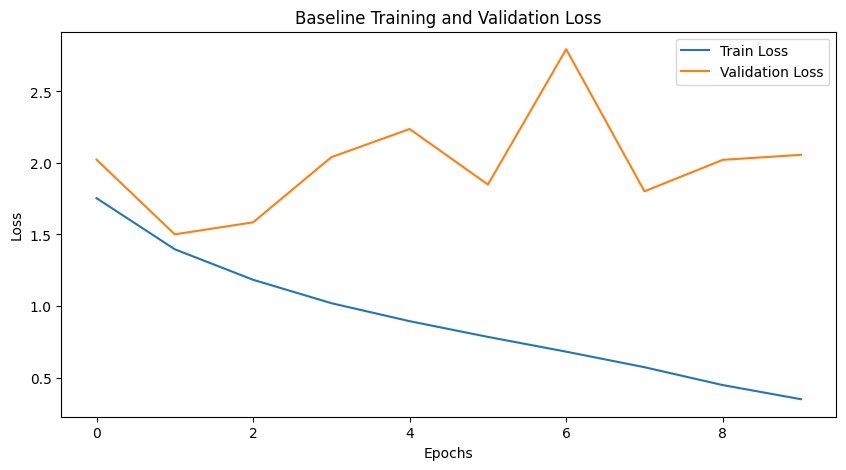

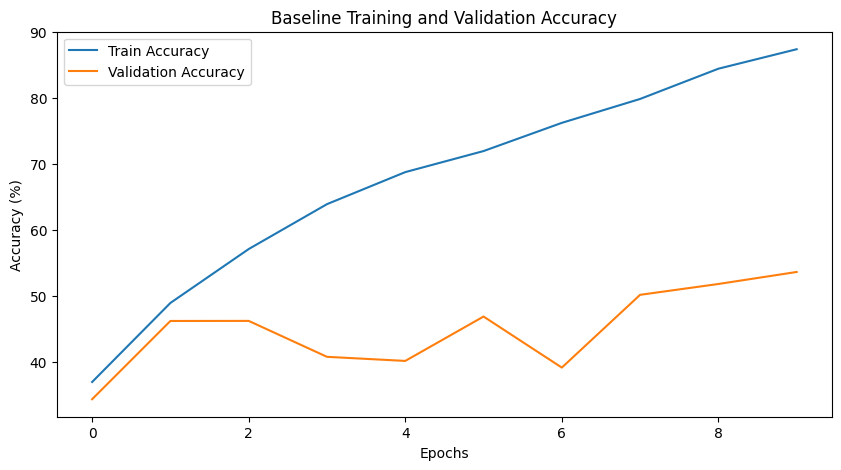

In [17]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Baseline Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Baseline Training and Validation Accuracy')
plt.legend()
plt.show()


# problem2 Mixup

1. Data Preparation

In [18]:
# Convert scalar labels to one-hot encoded labels for Mixup
def to_one_hot(labels, num_classes=10):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

y_train_one_hot = to_one_hot(torch.tensor(y_train_subset))
y_test_one_hot = to_one_hot(torch.tensor(test_labels))

# Create PyTorch datasets
train_dataset = TensorDataset(x_train_tensor, y_train_one_hot)
test_dataset = TensorDataset(x_test_tensor, y_test_one_hot)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)


In [19]:
print("x_train_tensor shape: ", x_train_tensor.shape, "y_train_scalar shape: ",y_train_scalar.shape)
print("x_test_tensor shape: ", x_test_tensor.shape, "y_test_scalar shape: ",y_test_scalar.shape)

x_train_tensor shape:  torch.Size([10000, 3, 32, 32]) y_train_scalar shape:  torch.Size([10000])
x_test_tensor shape:  torch.Size([10000, 3, 32, 32]) y_test_scalar shape:  torch.Size([10000])


2. Model Definition

Restart the resnet18 from fresh. No pretraining. re-specifiy the optimizer

In [20]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes

# # Loss function
criterion = nn.CrossEntropyLoss()

# # Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



3. Define Mixup Function

In [21]:
def mixup_data(x, y, alpha=0.2):
    """
    Apply Mixup augmentation to a batch of data and labels.

    Args:
        x (Tensor): Input data (e.g., images).
        y (Tensor): Corresponding one-hot encoded labels.
        alpha (float): Mixup interpolation parameter.

    Returns:
        Tuple[Tensor, Tensor]: Mixed inputs and labels.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index, :]
    return mixed_x, mixed_y


4. Training Function

In [22]:
def train_with_mixup(model, train_loader, test_loader, criterion, optimizer, alpha=0.2, num_epochs=10, device='cuda'):
  model.to(device)

  # Lists to store metrics
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)

      # Apply Mixup
      mixed_inputs, mixed_targets = mixup_data(inputs, targets, alpha)
      mixed_inputs, mixed_targets = mixed_inputs.to(device), mixed_targets.to(device)

      # Forward pass
      optimizer.zero_grad()
      outputs = model(mixed_inputs)
      loss = criterion(outputs, torch.argmax(mixed_targets, dim=1))

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      # Update metrics
      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += targets.size(0)
      correct += (predicted == torch.argmax(targets, dim=1)).sum().item()

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on the validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(targets, dim=1))

        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_total += targets.size(0)
        val_correct += (predicted == torch.argmax(targets, dim=1)).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    #print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    print(f"Epoch {epoch + 1}, \tTrain Loss: {train_loss:.4f}, \tTrain Acc: {train_accuracy:.2f}%, \tVal Loss: {val_loss:.4f}, \tVal Acc: {val_accuracy:.2f}%\n")

  return train_losses, train_accuracies, val_losses, val_accuracies


5. Train the Model with alpha = 0.2

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train_with_mixup(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    alpha=0.2,
    num_epochs=10,
    device=device
)


Epoch 1/10
Epoch 1, 	Train Loss: 1.7874, 	Train Acc: 24.63%, 	Val Loss: 2.1333, 	Val Acc: 35.20%

Epoch 2/10
Epoch 2, 	Train Loss: 1.5086, 	Train Acc: 29.49%, 	Val Loss: 1.7120, 	Val Acc: 41.53%

Epoch 3/10
Epoch 3, 	Train Loss: 1.3003, 	Train Acc: 30.49%, 	Val Loss: 1.4215, 	Val Acc: 48.53%

Epoch 4/10
Epoch 4, 	Train Loss: 1.2062, 	Train Acc: 36.34%, 	Val Loss: 1.4629, 	Val Acc: 47.84%

Epoch 5/10
Epoch 5, 	Train Loss: 1.0754, 	Train Acc: 36.09%, 	Val Loss: 1.7204, 	Val Acc: 42.56%

Epoch 6/10


6. Plot Metrics

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Mixup Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Mixup Training and Validation Accuracy')
plt.legend()
plt.show()


Aplha = 0.4

In [ ]:
# reset the model and optimizer for alpha=0.4
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train with alpha=0.4
train_losses04, train_accuracies04, val_losses04, val_accuracies04 = train_with_mixup(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    alpha=0.4,
    num_epochs=10,
    device=device
)


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses04, label='Train Loss')
plt.plot(val_losses04, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Mixup Training and Validation Loss with alpha = 0.4')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies04, label='Train Accuracy')
plt.plot(val_accuracies04, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Mixup Training and Validation Accuracy with alpha = 0.4')
plt.legend()
plt.show()


Plot both alpha = 0.2 and alpha = 0.4

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (alpha=0.2)')
plt.plot(val_losses, label='Validation Loss (alpha=0.2)')
plt.plot(train_losses04, label='Train Loss (alpha=0.4)', linestyle='dashed')
plt.plot(val_losses04, label='Validation Loss (alpha=0.4)', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Mixup)')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy (alpha=0.2)')
plt.plot(val_accuracies, label='Validation Accuracy (alpha=0.2)')
plt.plot(train_accuracies04, label='Train Accuracy (alpha=0.4)', linestyle='dashed')
plt.plot(val_accuracies04, label='Validation Accuracy (alpha=0.4)', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (Mixup)')
plt.legend()
plt.show()


# Problem 3 Cutout

1. Cutout Augmentation Function

In [ ]:
def cutout(image, cutout_size):
  """
  Applies Cutout augmentation to a single image.

  Parameters:
  - image: The input image tensor of shape [C, H, W].
  - cutout_size: The size (K) of the square cutout.

  Returns:
  - Augmented image tensor with a cutout region set to zero.
  """
  _, height, width = image.shape
  mask = np.ones((height, width), dtype=np.float32)

  # Randomly select the center of the cutout region
  y_center = np.random.randint(0, height)
  x_center = np.random.randint(0, width)

  # Define the cutout boundaries
  y1 = max(0, y_center - cutout_size // 2)
  y2 = min(height, y_center + cutout_size // 2)
  x1 = max(0, x_center - cutout_size // 2)
  x2 = min(width, x_center + cutout_size // 2)

  # Apply the mask (set the cutout region to zero)
  mask[y1:y2, x1:x2] = 0.0

  # Apply the mask to all channels
  image = image * torch.tensor(mask, dtype=image.dtype, device=image.device)

  return image


2. Define Cutout Transform Class

In [ ]:
class CutoutTransform:
    def __init__(self, cutout_size, probability=0.5):
        """
        Initialize the Cutout transformation.

        Parameters:
        - cutout_size: Size (K) of the cutout square.
        - probability: Probability of applying the Cutout transformation.
        """
        self.cutout_size = cutout_size
        self.probability = probability

    def __call__(self, image):
        """
        Apply Cutout with a specified probability.

        Parameters:
        - image: Input tensor of shape [C, H, W].

        Returns:
        - Transformed image tensor.
        """
        if np.random.rand() < self.probability:
            return cutout(image, self.cutout_size)
        return image


3. Dataset Preparation with Cutout

In [ ]:
# Convert NumPy arrays to PyTorch tensors and adjust dimensions
x_train_tensor = torch.tensor(x_train_subset, dtype=torch.float32).permute(0, 3, 1, 2)  # [batch, channels, height, width]
y_train_tensor = torch.tensor(y_train_subset)

x_test_tensor = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)  # [batch, channels, height, width]
y_test_tensor = torch.tensor(test_labels)

# Create PyTorch datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Apply Cutout transformation dynamically during data loading
train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=lambda batch: (
    torch.stack([CutoutTransform(cutout_size=16)(x) for x, _ in batch]),
    torch.tensor([y for _, y in batch])
))

test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=lambda batch: (
    torch.stack([x for x, _ in batch]),
    torch.tensor([y for _, y in batch])
))


4. Model Definition

In [ ]:
# Define the ResNet model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # For CIFAR-10

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


5. Training with cutout

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train_baseline(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


6. Visualize Cutout-Augmented Images

In [ ]:
# Visualize Cutout on training images
def visualize_cutout(loader):
    for images, _ in loader:
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            image = images[i].permute(1, 2, 0).numpy()
            axes[i].imshow(image)
            axes[i].axis('off')
        plt.show()
        break

visualize_cutout(train_loader)


7. PLot metrics

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Cut out Train Loss')
plt.plot(val_losses, label='Cut out Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cutout Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Cut out Train Accuracy')
plt.plot(val_accuracies, label='Cut out Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Cutout Training and Validation Accuracy')
plt.legend()
plt.show()

# Problem 4 standard augumentation

1. Define the Standard Augmentation Function

In [ ]:
def standard_augmentation(image, max_shift=4):
    """
    Apply standard augmentation: random shift and horizontal flip.

    Parameters:
    - image: Input image tensor of shape [C, H, W].
    - max_shift: Maximum shift in pixels (K).

    Returns:
    - Augmented image tensor.
    """
    _, height, width = image.shape

    # Randomly pick shift values k1 and k2
    k1 = np.random.randint(-max_shift, max_shift + 1)  # Vertical shift
    k2 = np.random.randint(-max_shift, max_shift + 1)  # Horizontal shift

    # Create a padded image with zero padding
    padded_image = torch.zeros_like(image).to(image.device)
    y_start = max(0, k1)
    y_end = height + min(0, k1)
    x_start = max(0, k2)
    x_end = width + min(0, k2)
    padded_image[:, y_start:y_end, x_start:x_end] = image[:, max(0, -k1):height - max(0, k1), max(0, -k2):width - max(0, k2)]

    # Apply horizontal flip with 50% probability
    if np.random.rand() < 0.5:
        padded_image = torch.flip(padded_image, dims=[2])  # Flip horizontally

    return padded_image


2. Define a Transform Class for Standard Augmentation

In [ ]:
class StandardAugmentationTransform:
    def __init__(self, max_shift=4, probability=0.5):
        """
        Initialize standard augmentation.

        Parameters:
        - max_shift: Maximum shift in pixels (K).
        - probability: Probability of applying horizontal flip.
        """
        self.max_shift = max_shift
        self.probability = probability

    def __call__(self, image):
        return standard_augmentation(image, max_shift=self.max_shift)


3. Update the DataLoader for Standard Augmentation

In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# # Create DataLoaders with standard augmentation
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=lambda batch: (
#     torch.stack([StandardAugmentationTransform(max_shift=4)(x) for x, _ in batch]),
#     torch.tensor([y for _, y in batch])
# ))

# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=lambda batch: (
#     torch.stack([x for x, _ in batch]),
#     torch.tensor([y for _, y in batch])
# ))


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Create DataLoaders with standard augmentation
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=lambda batch: (
    torch.stack([StandardAugmentationTransform(max_shift=4)(x) for x, _ in batch]),
    torch.tensor([y for _, y in batch])
))

test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=lambda batch: (
    torch.stack([x for x, _ in batch]),
    torch.tensor([y for _, y in batch])
))


Reset the model and optimizer for training

In [ ]:
# Reset the model and optimizer for training
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # For CIFAR-10

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

4. Train the Model with Standard Augmentation

In [ ]:


# Train the model with Standard Augmentation
train_losses, train_accuracies, val_losses, val_accuracies = train_baseline(
    model,
    train_loader,  # Data loader with standard augmentation
    test_loader,   # Standard test data loader
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


5. Visualize Augmented Images

In [ ]:

# Visualize standard augmentation on training images
def visualize_standard_augmentation(loader):
    for images, _ in loader:
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            image = images[i].permute(1, 2, 0).numpy()  # Convert to HWC for display
            axes[i].imshow(image)
            axes[i].axis('off')
        plt.show()
        break

visualize_standard_augmentation(train_loader)


standard augumentation plot metric

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Standard Train Loss')
plt.plot(val_losses, label='Standard Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cutout Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='CStandard Train Accuracy')
plt.plot(val_accuracies, label='Standard Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Cutout Training and Validation Accuracy')
plt.legend()
plt.show()

# Problem 5

Combined Augmentation Pipeline
We will:

1. Apply Standard Augmentation (shifting and flipping).
2. Apply Cutout.
3. Use Mixup as the final augmentation during training.
Standard + Cutout Augmentation Transform

In [ ]:
class CombinedTransform:
    def __init__(self, cutout_size=16, max_shift=4, mixup_alpha=0.2, mixup_prob=0.5):
        """
        Initialize combined augmentation.

        Parameters:
        - cutout_size: Size of the Cutout square.
        - max_shift: Maximum shift for standard augmentation.
        - mixup_alpha: Alpha parameter for Mixup augmentation.
        - mixup_prob: Probability of applying Mixup.
        """
        self.cutout_size = cutout_size
        self.max_shift = max_shift
        self.mixup_alpha = mixup_alpha
        self.mixup_prob = mixup_prob

    def apply_standard_and_cutout(self, image):
        """
        Apply Standard Augmentation and Cutout to an image.
        """
        # Standard augmentation (shift and flip)
        image = standard_augmentation(image, max_shift=self.max_shift)
        # Apply Cutout
        image = cutout(image, cutout_size=self.cutout_size)
        return image

    def __call__(self, images, labels):
        """
        Apply the combined augmentation pipeline:
        - Standard Augmentation + Cutout
        - Mixup

        Parameters:
        - images: Tensor of shape [batch_size, C, H, W].
        - labels: Tensor of one-hot encoded labels.

        Returns:
        - Augmented images and labels.
        """
        # Apply Standard + Cutout to all images in the batch
        augmented_images = torch.stack([self.apply_standard_and_cutout(img) for img in images])

        # Apply Mixup with probability
        if np.random.rand() < self.mixup_prob:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            indices = torch.randperm(augmented_images.size(0))
            mixed_images = lam * augmented_images + (1 - lam) * augmented_images[indices, :]
            mixed_labels = lam * labels + (1 - lam) * labels[indices]
            return mixed_images, mixed_labels

        return augmented_images, labels


2. Dataset Loader with Combined Augmentation

In [ ]:
# Convert scalar labels to one-hot encoded labels
def to_one_hot(labels, num_classes=10):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

y_train_one_hot = to_one_hot(torch.tensor(y_train_subset, dtype=torch.long))
y_test_one_hot = to_one_hot(torch.tensor(test_labels, dtype=torch.long))

# DataLoader with Combined Augmentation
combined_transform = CombinedTransform(cutout_size=16, max_shift=4, mixup_alpha=0.2)  # Use α=0.2 based on observation

# DataLoader with Combined Augmentation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=lambda batch: combined_transform(
    torch.stack([x for x, _ in batch]),  # Images
    torch.stack([to_one_hot(y, num_classes=10) for _, y in batch])  # One-hot encoded labels
))

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=lambda batch: (
    torch.stack([x for x, _ in batch]),
    torch.stack([to_one_hot(y, num_classes=10) for _, y in batch])
))



3. Training Function

In [ ]:
def train_combined(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    """
    Train the model with combined augmentation and collect metrics for plotting.
    """
    model.to(device)

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(targets, dim=1))  # Use scalar labels for CrossEntropyLoss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == torch.argmax(targets, dim=1)).sum().item()

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on the validation set
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, torch.argmax(targets, dim=1))  # Use scalar labels for CrossEntropyLoss

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == torch.argmax(targets, dim=1)).sum().item()

        val_loss /= len(test_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies


4. Train the Model with Combined Augmentation

In [ ]:
# Reset the model and optimizer
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # For CIFAR-10

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model with Combined Augmentation
train_losses, train_accuracies, val_losses, val_accuracies = train_combined(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


5. Visualize Results
To analyze the results.
Plot Loss and accuracy for both training and validation


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Combined Augmentation: Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Combined Augmentation: Training and Validation Accuracy')
plt.legend()
plt.show()


# Some random test

In [ ]:
# Reset the model and optimizer
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # For CIFAR-10

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model with Combined Augmentation
train_losses, train_accuracies, val_losses, val_accuracies = train_combined(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=20,
    device=device
)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Combined Augmentation: Training and Validation Accuracy')
plt.legend()
plt.show()


# Commentary on the Role of Data Augmentation



Data augmentation introduces diversity to the training dataset by applying transformations such as Mixup, Cutout, and Standard Augmentation. Its role is to improve the generalization ability of models and reduce overfitting. Here's an analysis based on the plots and results:

---

#### **1. Test Accuracy**
- **Observation**: Data augmentation consistently improves test accuracy. For example:
  - Mixup augmentation achieves higher test accuracy compared to the baseline.
  - Combined augmentations (Standard + Cutout + Mixup) deliver the best test accuracy due to the synergistic effects of multiple augmentations.
  
- **Reason**: Augmentation techniques create a more robust training dataset by simulating real-world variations, enabling the model to generalize better to unseen test data.

---

#### **2. Train Accuracy**
- **Observation**: Train accuracy is generally lower with data augmentation compared to the baseline.
  - In the baseline model, train accuracy grows quickly because the model memorizes the training data.
  - With augmentations like Cutout or Mixup, train accuracy improves more slowly, as these methods create more challenging and variable training samples.

- **Reason**: Augmented data makes the optimization problem harder by introducing new variations, which prevents the model from overfitting to the training data.

---

#### **3. Convergence of Optimization**
- **Observation**:
  - Training loss in the baseline model converges faster but shows signs of overfitting (train accuracy is much higher than test accuracy).
  - With data augmentation, training loss converges more gradually due to the added variability in the training data.

- **Reason**: Augmentation forces the model to learn more generalized features rather than memorizing specific training samples, which slows down convergence but improves the overall quality of optimization.

---

#### **4. Comparison of Augmentation Methods**
- **Mixup**:
  - Encourages smoother decision boundaries by blending images and labels.
  - Leads to higher test accuracy but slower convergence compared to the baseline.
  
- **Cutout**:
  - Helps the model focus on multiple parts of an image by occluding random regions.
  - Improves test accuracy but can introduce variability that slightly slows down training accuracy improvement.
  
- **Standard Augmentation**:
  - Shifts and flips images to simulate spatial variations.
  - Provides moderate improvements in both train and test accuracy.

- **Combined Augmentation**:
  - Achieves the best balance by leveraging the strengths of multiple augmentation methods.
  - Results in higher test accuracy and robust generalization at the cost of slower convergence.

---

#### **Conclusion**
Data augmentation plays a critical role in improving test accuracy and mitigating overfitting. While it slows down the training process and reduces training accuracy, it ensures the model generalizes better to unseen data. The combination of augmentations leads to the best results, as it leverages the strengths of individual methods to address different aspects of model robustness.